In [33]:
import torch
tv = torch.__version__
cv = torch.version.cuda
# print(cv)  # change this to the following format...
cv = "cu101"
# print(tv)
link = "https://pytorch-geometric.com/whl/torch-" + tv + ".html"
!pip install torch-scatter==latest+{cv} -f {link}
!pip install torch-sparse==latest+{cv} -f {link}
!pip install torch-cluster==latest+{cv} -f {link}
!pip install torch-spline-conv==latest+{cv} -f {link}
!pip install torch-geometric
!pip install networkx 

# used for distance calculation between cities
!pip install geopy  


In [60]:
# get data from here - https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data?select=GlobalLandTemperaturesByCity.csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx
# from vincenty import vincenty
from geopy.distance import vincenty
import geopy

# read data, take only data for USA at the most recent date (day)
df = pd.read_csv('../GlobalLandTemperaturesByCity.csv')
df = df[df['Country']=="United States"]
df = df[df['dt']=="2013-09-01"]
df = df.fillna(0)

df = df.head(20)  # used for testing...



In [66]:
# create the graph - 
graph= networkx.Graph()

# todo - add vertices - one for each city
for idx, row in enumerate(df.iterrows()):
    graph.add_node(row[1]["City"])

for idx1, row1 in enumerate(df.iterrows()):
    for idx2, row2 in enumerate(df.iterrows()):
        pos1 = geopy.Point.from_string(row1[1]["Latitude"] + " " + row1[1]["Longitude"])
        pos2 = geopy.Point.from_string(row2[1]["Latitude"] + " " + row2[1]["Longitude"])
        distance = vincenty(pos1, pos2).meters #geopy distance
        # print(idx1, idx2, distance)
        graph.add_edge(row1[1]["City"], row2[1]["City"], weight=distance)

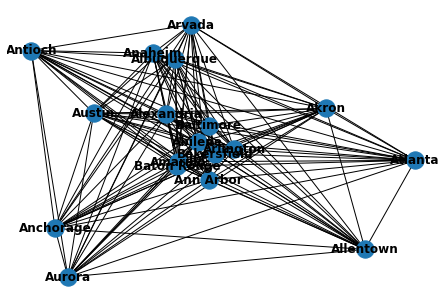

In [67]:
networkx.draw(graph, with_labels=True, font_weight='bold')

# from networkx.drawing.nx_agraph import graphviz_layout
# pos = graphviz_layout(graph)
# plt.axis('off')
# nx.draw_networkx_nodes(graph,pos,node_color='g',alpha = 0.8)  # draws nodes
# nx.draw_networkx_edges(graph,pos,edge_color='b',alpha = 0.6)  # draws edges
# nx.draw_networkx_edge_labels(graph,pos,edge_labels = nx.get_edge_attributes(graph,'weight')) # edge lables
# nx.draw_networkx_labels(graph,pos) # node lables